In [1]:
import praw
from datetime import datetime
import os


from dotenv import load_dotenv

load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    user_agent=os.getenv("USER_AGENT"),
)

In [2]:
def get_submission_data(subreddit_name, limit=500):
    subreddit = reddit.subreddit(subreddit_name)
    data = []
    for submission in subreddit.new(limit=limit):  
        data.append({
            "title": submission.title,
            "created_utc": submission.created_utc,
            "score": submission.score,
            "num_comments": submission.num_comments
        })
        
    return data

data = get_submission_data("fitness")


In [3]:
import pandas as pd

def analyze_posting_times(data):
    df = pd.DataFrame(data)
    df['created_at'] = pd.to_datetime(df['created_utc'], unit='s')
    df['hour'] = df['created_at'].dt.hour
    df['day_of_week'] = df['created_at'].dt.day_name()
    grouped = df.groupby(['day_of_week', 'hour']).agg({
        'score': 'mean',
        'num_comments': 'mean'
    }).reset_index()
    
    grouped['engagement_score'] = (
            df['score'] * 0.5 + 
            df['num_comments'] * 0.5
        )
    
    return grouped.sort_values('engagement_score', ascending=False)

dat = analyze_posting_times(data)



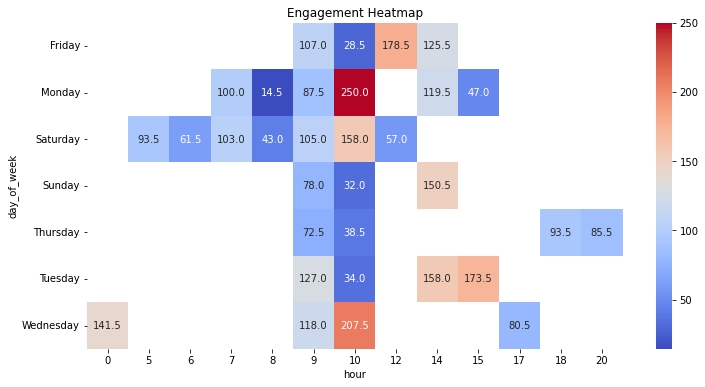

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_engagement_heatmap(grouped_data):
    pivot_table = grouped_data.pivot("day_of_week", "hour", "engagement_score")
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f")
    plt.title("Engagement Heatmap")
    plt.show()
    
plot_engagement_heatmap(dat)


In [5]:
def get_best_posting_times(subreddits):
    results = {}
    for subreddit in subreddits:
        data = get_submission_data(subreddit)
        grouped_data = analyze_posting_times(data)
        best_times = grouped_data.head(5)  
        results[subreddit] = best_times
    return results

get_best_posting_times(["fitness", "shoes"])

{'fitness':    day_of_week  hour       score  num_comments  engagement_score
 7       Monday    10   31.000000    252.000000             253.0
 30   Wednesday    10   37.421053    226.789474             208.0
 2       Friday    12   29.000000     24.000000             179.5
 27     Tuesday    15  683.000000    252.000000             175.5
 26     Tuesday    14   46.000000     42.000000             158.5,
 'shoes':     day_of_week  hour     score  num_comments  engagement_score
 123     Tuesday    16  1.000000      3.000000             193.5
 87     Thursday     0  1.000000      0.000000              51.5
 39       Monday    19  1.500000      0.500000              25.0
 65       Sunday     0  0.666667      9.666667              24.0
 4        Friday     4  1.333333      1.666667              21.0}